In [22]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from imblearn.over_sampling import ADASYN
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Step 1: Load the combined features
def load_features(filepath='/content/drive/My Drive/SMM/csv_files/combined_features_embeddings_only.csv'):
    """
    Load the combined features dataset
    """
    df = pd.read_csv(filepath)
    print(f"Features loaded with shape: {df.shape}")
    return df

In [25]:
# Step 2: Split the data into train and test sets
def split_data(df, target_column='class', test_size=0.3, random_state=42):
    """
    Split the data into training and testing sets
    """
    print(f"\nSplitting data into train and test sets (test_size={test_size})...")

    # Separate features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")

    # Display class distribution in splits
    print("\nClass distribution in training set:")
    print(pd.Series(y_train).value_counts(normalize=True).sort_index() * 100)

    print("\nClass distribution in testing set:")
    print(pd.Series(y_test).value_counts(normalize=True).sort_index() * 100)

    return X_train, X_test, y_train, y_test

In [26]:
# Step 3: Apply ADASYN for handling class imbalance
def apply_adasyn(X_train, y_train, random_state=42):
    """
    Apply ADASYN to oversample minority classes
    """
    print("\nApplying ADASYN oversampling to handle class imbalance...")

    # Before oversampling
    print("Class distribution before oversampling:")
    print(pd.Series(y_train).value_counts().sort_index())

    # Apply ADASYN
    try:
        adasyn = ADASYN(random_state=random_state, n_neighbors=5)
        X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

        # After oversampling
        print("\nClass distribution after ADASYN oversampling:")
        print(pd.Series(y_resampled).value_counts().sort_index())

        return X_resampled, y_resampled
    except Exception as e:
        print(f"Error applying ADASYN: {e}")
        print("Falling back to original data...")
        return X_train, y_train

In [27]:
#Train XGBoost model

def train_xgboost_model(X_train, y_train, random_state=42):
    """
    Train an XGBoost classifier
    """
    print("\nTraining XGBoost model ")



    # Initialize XGBoost classifier
    model = xgb.XGBClassifier(
        objective='multi:softprob',  # Multi-class probability
        num_class=3,  # Number of classes: hate speech, offensive language, neither
        random_state=random_state,
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_estimators=150,  # Increase number of trees
        max_depth=5,               # Reduced from 7
        learning_rate=0.08,        # Reduced from 0.1
        subsample=0.9,             # Add subsample parameter
        colsample_bytree=0.9,      # Use 80% of features per tree
        reg_alpha=0.05,             # L1 regularization
        reg_lambda=0.5
    )

    # Train the model with sample weights
    model.fit(
        X_train, y_train,
        verbose=True
    )

    print("XGBoost model training completed")

    return model


In [28]:
# Step 4: Evaluate model performance
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance on test set
    """
    print("\nEvaluating model performance...")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Calculate metrics
    class_names = ['Hate Speech', 'Offensive', 'Neither']

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the model :{accuracy:.4f}")

    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average='weighted'
    )
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")

    # Print confusion matrix in tabular format
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(cm, index=class_names, columns=class_names))

    # Calculate and display metrics per class
    print("\nMetrics per class:")
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None
    )

    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  F1-score: {f1_per_class[i]:.4f}")

    return y_pred, y_pred_proba

In [29]:
# Step 5: Visualize model performance
def visualize_performance(model, X_test, y_test, y_pred, y_pred_proba):
    """
    Create visualizations of model performance
    """
    print("\nCreating performance visualizations...")

    # Set up aesthetics
    sns.set(style='whitegrid')
    plt.rcParams.update({'font.size': 12})

   # Plot 1: Confusion Matrix - Raw counts
    plt.figure(figsize=(12, 10))  # Increased figure size
    cm = confusion_matrix(y_test, y_pred)

    class_names = ['Hate Speech', 'Offensive', 'Neither']
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='YlOrRd',  # Changed colormap to Yellow-Orange-Red
        xticklabels=class_names,
        yticklabels=class_names,
        annot_kws={"size": 24}  # Larger annotation font size
    )

    # Increase tick label font size
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

    plt.title('Confusion Matrix', fontsize=20)  # Larger title font
    plt.xlabel('Predicted Label', fontsize=18)  # Larger x-label font
    plt.ylabel('True Label', fontsize=18)  # Larger y-label font
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/SMM/Images/Ensemble/confusion_matrix.png')
    plt.show()
    plt.close()

    # Plot 2: ROC Curves (One-vs-Rest)
    plt.figure(figsize=(12, 8))

    # One vs Rest ROC curve for each class
    for i, class_name in enumerate(class_names):
        # Prepare binary labels for the current class
        y_test_binary = (y_test == i).astype(int)

        # Get probability scores for the current class
        y_score = y_pred_proba[:, i]

        # Compute ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_test_binary, y_score)
        roc_auc = roc_auc_score(y_test_binary, y_score)

        # Plot ROC curve
        plt.plot(
            fpr,
            tpr,
            lw=2,
            label=f'ROC curve (class: {class_name}, area = {roc_auc:.2f})'
        )

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/SMM/Images/Ensemble/roc_curves.png')
    plt.show()
    plt.close()

    print("Performance visualizations saved")
    # Plot 4: Feature Importance
    plt.figure(figsize=(12, 10))

    # Get feature importance
    importances = model.feature_importances_
    feature_names = X_test.columns

    # Sort features by importance
    indices = np.argsort(importances)[-20:]  # Top 20 features

    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title('XGBoost Feature Importance (Top 20)', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/SMM/Images/Ensemble/feature_importance.png', dpi=300)
    plt.show()
    plt.close()

    # Plot 5: Class Distribution Before and After ADASYN (for reporting)
    plt.figure(figsize=(10, 6))

    # Original class distribution in test set
    ax = plt.subplot(111)
    test_class_counts = pd.Series(y_test).value_counts().sort_index()
    test_class_counts.index = [class_names[i] for i in test_class_counts.index]
    sns.barplot(x=test_class_counts.index, y=test_class_counts.values, ax=ax)
    plt.title('Class Distribution in Test Set', fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/SMM/Images/Ensemble/test_class_distribution.png', dpi=300)
    plt.show()
    plt.close()

    print("Performance visualizations saved")



In [30]:
# Step 6: Save the model
def save_model(model, filename='/content/drive/My Drive/SMM/xgboost_hate_speech_model.pkl'):
    """
    Save the trained model to a file
    """
    print(f"\nSaving model to {filename}...")

    with open(filename, 'wb') as f:
        pickle.dump(model, f)

    print("Model saved successfully")

In [31]:
# Main function
def main():
    # Step 1: Load features
    df = load_features()

    # Step 2: Split the data
    X_train, X_test, y_train, y_test = split_data(df)

    # Step 3: Apply ADASYN to handle class imbalance
    X_train, y_train = apply_adasyn(X_train, y_train)

    # Step 3: Train model with class weights
    model = train_xgboost_model(X_train, y_train)

    # Step 4: Evaluate model
    y_pred, y_pred_proba = evaluate_model(model, X_test, y_test)


    # Step 5: Visualize performance
    visualize_performance(model, X_test, y_test, y_pred, y_pred_proba)

    # Step 6: Save model
    save_model(model)

    print("\nModel building completed successfully!")

    return model, X_train, X_test, y_train, y_test

Features loaded with shape: (24783, 1025)

Splitting data into train and test sets (test_size=0.3)...
Training set: 17348 samples
Testing set: 7435 samples

Class distribution in training set:
class
0     5.770118
1    77.432557
2    16.797325
Name: proportion, dtype: float64

Class distribution in testing set:
class
0     5.770007
1    77.431069
2    16.798924
Name: proportion, dtype: float64

Applying ADASYN oversampling to handle class imbalance...
Class distribution before oversampling:
class
0     1001
1    13433
2     2914
Name: count, dtype: int64

Class distribution after ADASYN oversampling:
class
0    13557
1    13433
2    13443
Name: count, dtype: int64

Training XGBoost model 
XGBoost model training completed

Evaluating model performance...

Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.38      0.53      0.44       429
   Offensive       0.95      0.86      0.91      5757
     Neither       0.69      0.88      0.77      

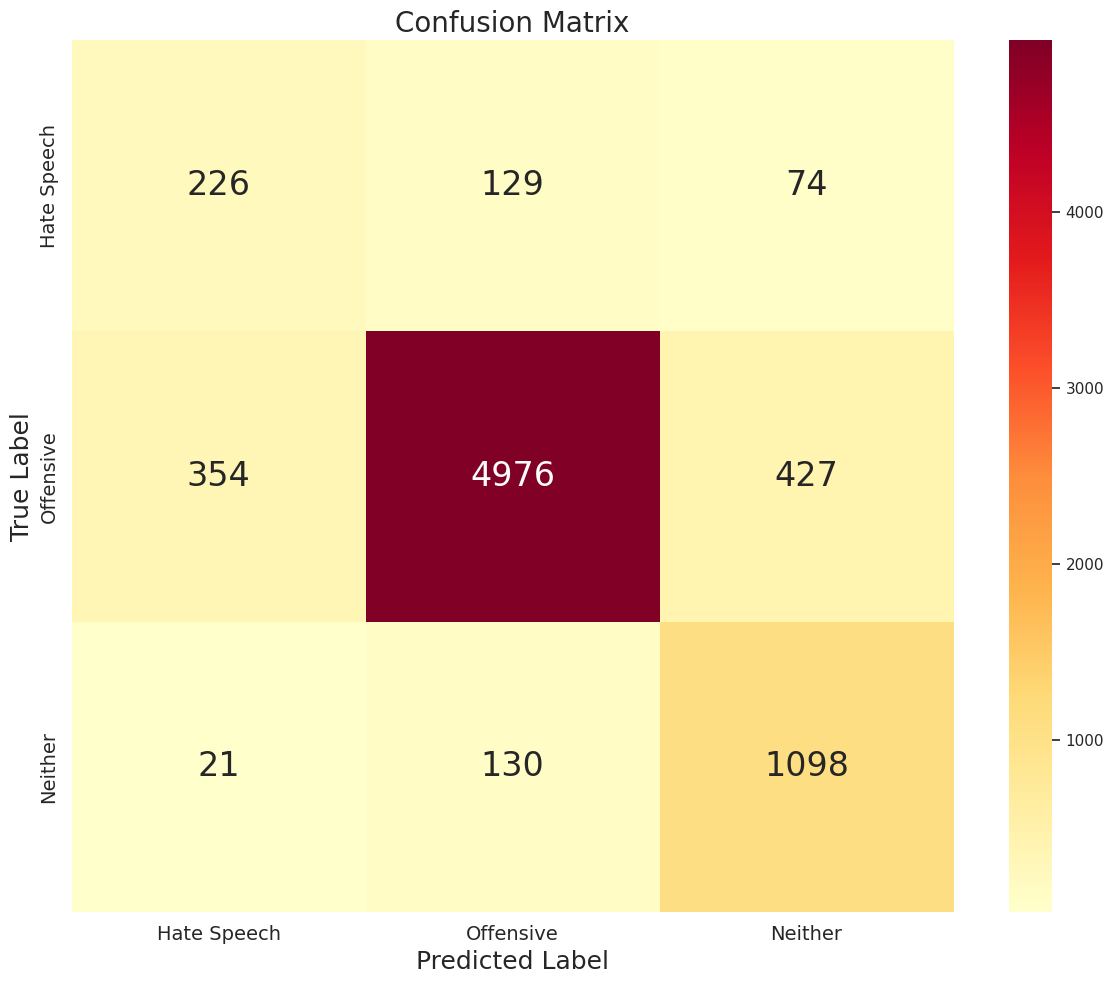

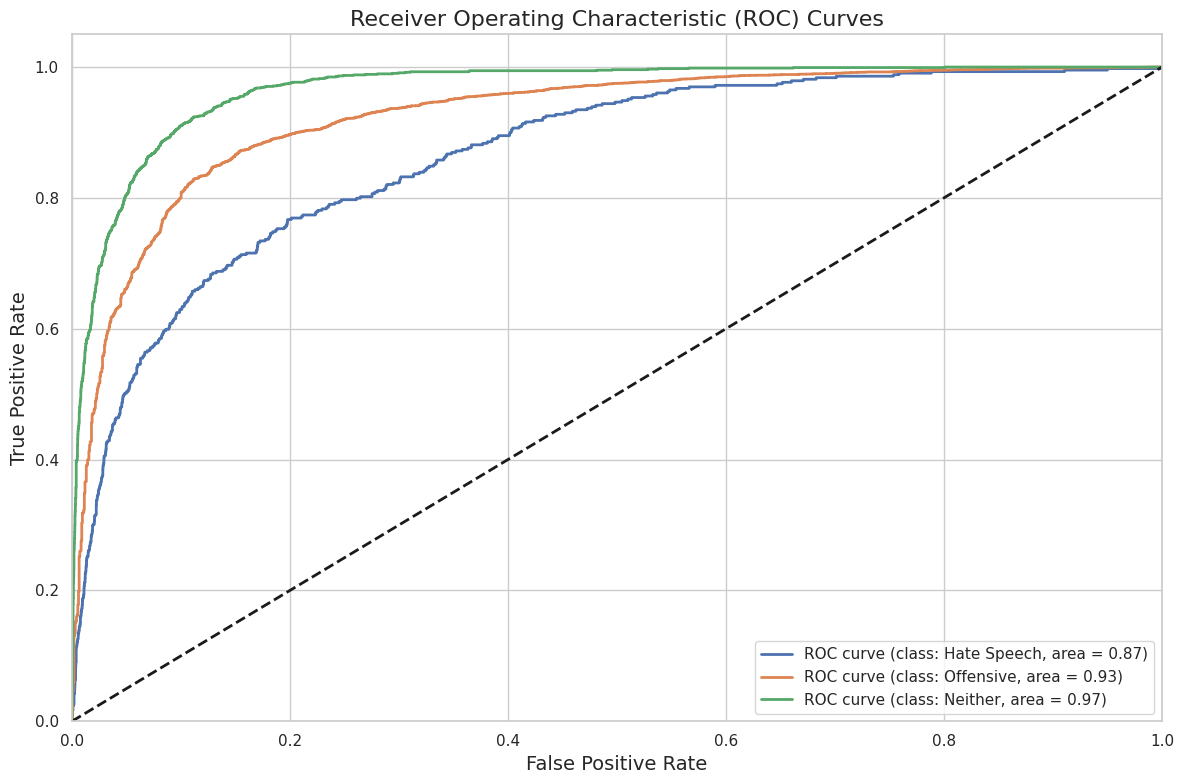

Performance visualizations saved


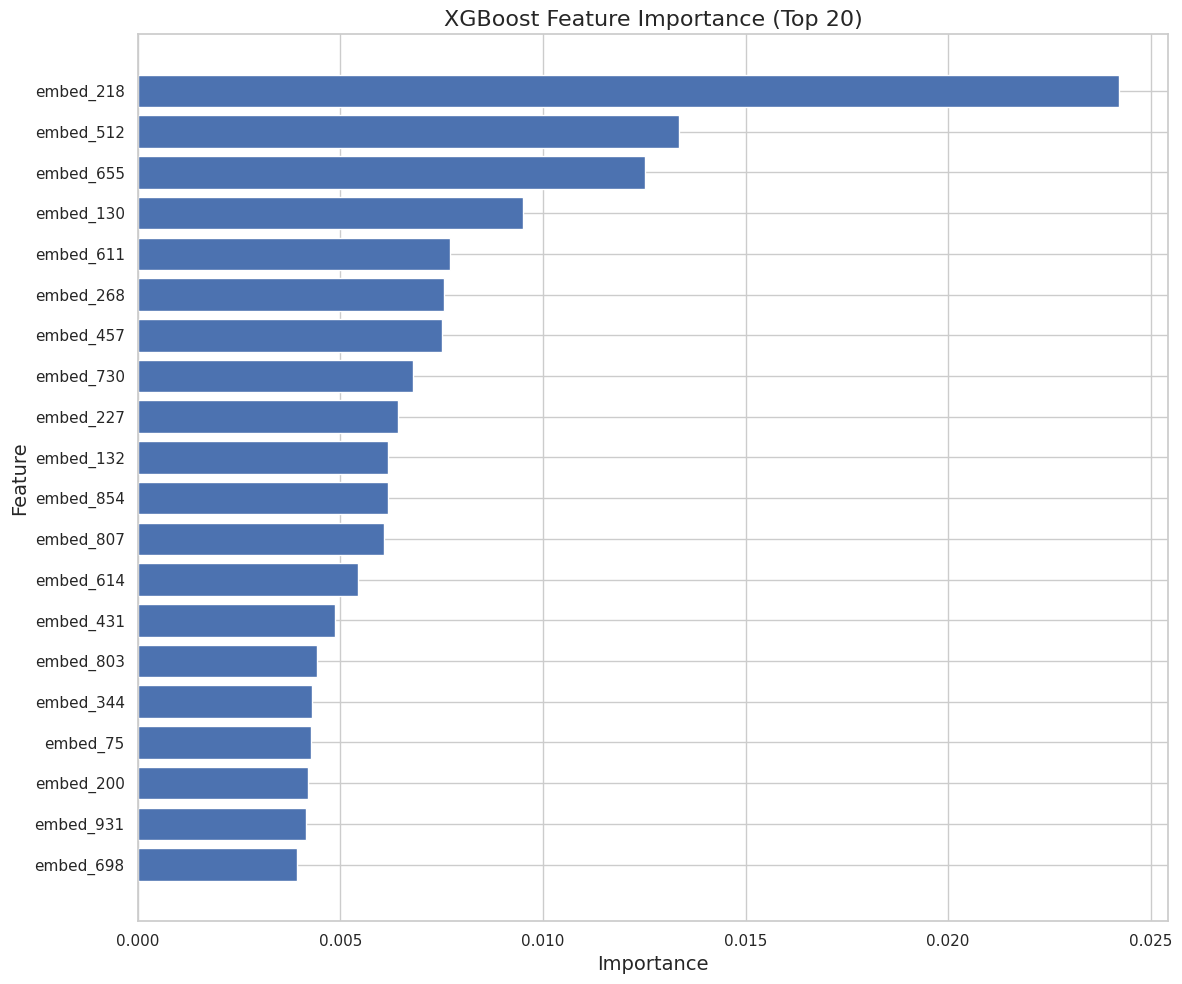

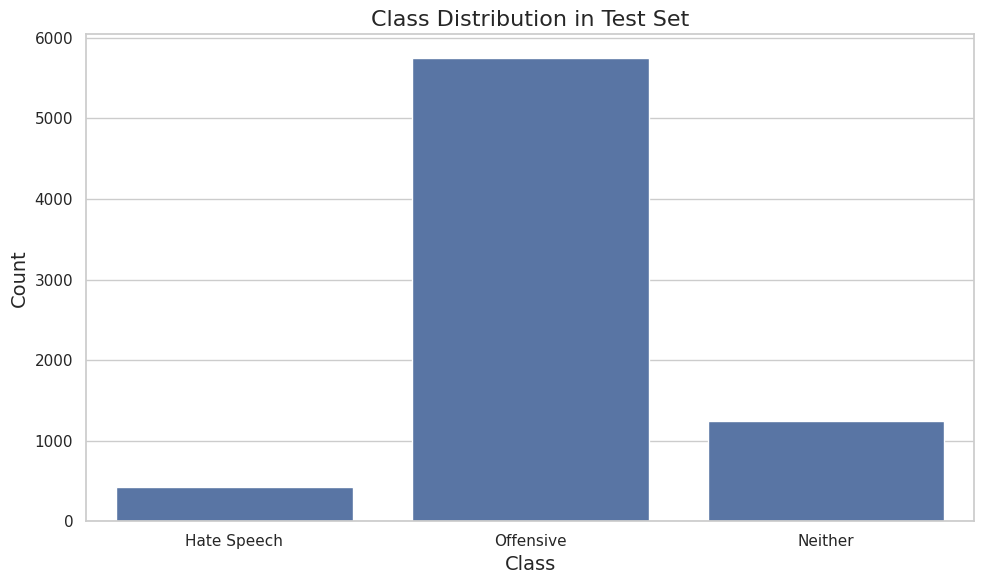

Performance visualizations saved

Saving model to /content/drive/My Drive/SMM/xgboost_hate_speech_model.pkl...
Model saved successfully

Model building completed successfully!


In [32]:
if __name__ == "__main__":
    main()